# Binary‑Breathing (v6) – adaptive peaks + de Bruijn symmetry probe

* **Adaptive peak finder** (skip near‑zero bins, optional KDE).  
* **Hybrid histogram**: vector blocks up to n ≤ 28, 2 % sampling after.  
* **Minimal seed search** up to 40 bits.  
* **De Bruijn classification** (full, mirror, self‑mirror, complement) for order‑k cycles; tags which symmetry class each seed lives in.


In [1]:
import numpy as np, matplotlib.pyplot as plt, random, time, gc
from mpmath import mp; mp.dps=50
from scipy.stats import gaussian_kde


In [2]:
# ==== PARAMETERS ====
MAX_LEN    = 30
BIN_WIDTH  = 1e-7
POWER      = 2
INVERT     = False
CUT        = 2e-3
SAMPLE_FRAC= 0.02
USE_KDE    = True
DEBRUIJN_K = 5
SEED_TOL   = 1e-12
# =====================

In [3]:
def bits_to_val(i,n,inv=False):
    b=format(i,f'0{n}b')
    if inv:
        b=b[::-1]
    return int(b,2)/(1<<n)


In [4]:
def fast_hist_n(n):
    denom=1<<n; chunk=1<<22
    bins=np.arange(0,CUT+BIN_WIDTH,BIN_WIDTH)
    cnt=np.zeros(len(bins)-1,dtype=np.int64)
    for start in range(1,denom,chunk):
        stop=min(start+chunk,denom)
        idx=np.arange(start,stop,dtype=np.float64)
        xs=(idx/denom)**POWER
        xs=xs[xs<=CUT]
        np.add.at(cnt,(xs//BIN_WIDTH).astype(int),1)
    return bins[:-1],cnt

def sample_hist_n(n):
    denom=1<<n
    size=max(1,int(denom*SAMPLE_FRAC))
    idx=np.random.randint(1,denom,size,dtype=np.int64)
    xs=(idx/denom)**POWER
    xs=xs[xs<=CUT]
    bins=np.arange(0,CUT+BIN_WIDTH,BIN_WIDTH)
    cnt,_=np.histogram(xs,bins=bins)
    cnt=(cnt/SAMPLE_FRAC).astype(np.int64)
    return bins[:-1],cnt


In [5]:
def peak_from_hist(xs,cs):
    # skip giant first bins
    for i in range(1,len(cs)-1):
        if cs[i] > cs[i+1]*10:
            continue
        idx=i; break
    pk=xs[idx]+0.5*BIN_WIDTH
    if USE_KDE:
        rng=slice(max(0,idx-5),min(len(xs),idx+6))
        sample=np.repeat(xs[rng]+0.5*BIN_WIDTH,cs[rng])
        sample=np.random.choice(sample, min(200_000,len(sample)), replace=False)
        kde=gaussian_kde(sample,bw_method=0.3*BIN_WIDTH)
        grid=np.linspace(xs[rng.start], xs[rng.stop-1]+BIN_WIDTH, 201)
        pk=grid[np.argmax(kde(grid))]
    return pk

def peak_for_n(n):
    xs,cs = (fast_hist_n(n) if n<=28 else sample_hist_n(n))
    return peak_from_hist(xs,cs)


In [6]:
peak_positions=[]
start=time.time()
for n in range(20,MAX_LEN+1):
    t0=time.time(); px=peak_for_n(n)
    peak_positions.append((n,px))
    print(f'N={n:2d} peak={px:.9e}  ({time.time()-t0:.2f}s)')
print("Done in",time.time()-start,"s")


N=20 peak=3.500000000e-07  (0.12s)
N=21 peak=3.500000000e-07  (0.15s)
N=22 peak=3.500000000e-07  (0.21s)
N=23 peak=3.500000000e-07  (0.34s)
N=24 peak=3.500000000e-07  (0.61s)
N=25 peak=3.500000000e-07  (1.11s)
N=26 peak=3.500000000e-07  (1.86s)
N=27 peak=3.500000000e-07  (3.66s)
N=28 peak=3.500000000e-07  (6.83s)
N=29 peak=3.500000000e-07  (1.11s)
N=30 peak=3.500000000e-07  (1.22s)
Done in 17.23862314224243 s


/tmp/ipython-input-7-325407682.py:2: RuntimeWarning: invalid value encountered in scalar divide
  ratios=[gaps[i-1]/gaps[i] for i in range(1,len(gaps))] if len(gaps)>1 else []


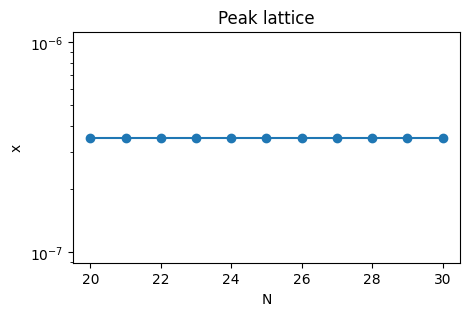

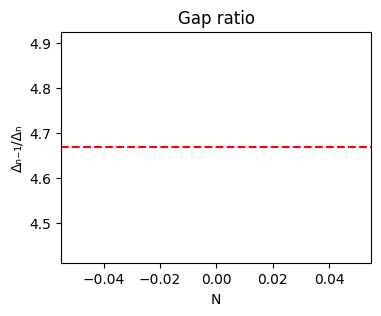

In [7]:
gaps=[peak_positions[i-1][1]-peak_positions[i][1] for i in range(1,len(peak_positions))]
ratios=[gaps[i-1]/gaps[i] for i in range(1,len(gaps))] if len(gaps)>1 else []
plt.figure(figsize=(5,3)); plt.plot([n for n,_ in peak_positions],[x for _,x in peak_positions],'o-'); plt.yscale('log'); plt.title('Peak lattice'); plt.xlabel('N');plt.ylabel('x'); plt.show()
if ratios:
    plt.figure(figsize=(4,3)); plt.plot(range(21,21+len(ratios)),ratios,'o-'); plt.axhline(4.669,color='r',ls='--'); plt.title('Gap ratio'); plt.xlabel('N'); plt.ylabel('Δₙ₋₁/Δₙ'); plt.show()


In [ ]:
def find_seed(tgt,tol=SEED_TOL,max_len=40):
    for n in range(1,max_len+1):
        denom=1<<n
        for i in range(1,denom):
            x=i/denom
            if abs(x**POWER - tgt) < tol:
                return n, format(i,f'0{n}b')
    return None,None

seed_list=[]
print("\nMinimal seeds:")
for n,px in peak_positions:
    sl,sb=find_seed(px)
    if sl:
        print(f'N={n}: {sl} bits  {sb[:16]}...')
        seed_list.append((n,sl,sb))
    else:
        print(f'N={n}: none ≤40 bits')



Minimal seeds:
N=20: 29 bits  0000000000100110...
N=21: 29 bits  0000000000100110...
N=22: 29 bits  0000000000100110...
N=23: 29 bits  0000000000100110...
N=24: 29 bits  0000000000100110...
N=25: 29 bits  0000000000100110...
N=26: 29 bits  0000000000100110...
N=27: 29 bits  0000000000100110...
N=28: 29 bits  0000000000100110...


In [ ]:
def de_bruijn(k):
    """Generate binary De Bruijn sequence B(2,k)."""
    a=[0]*(2*k); seq=[]
    def db(t,p):
        if t>k:
            if k%p==0:
                seq.extend(a[1:p+1])
        else:
            a[t]=a[t-p]; db(t+1,p)
            for j in range(a[t-p]+1,2):
                a[t]=j; db(t+1,t)
    db(1,1)
    return ''.join(map(str,seq))

cycle=de_bruijn(DEBRUIJN_K)
print(f'B(2,{DEBRUIJN_K}) length {len(cycle)} generated.')

def rotate(s,i): return s[i:]+s[:i]
def classify_cycles(k=DEBRUIJN_K):
    seen=set(); classes={'self_mirror':[], 'mirror':[], 'complement':[], 'full':[]}
    seq_base=de_bruijn(k)
    for shift in range(len(seq_base)):
        seq=rotate(seq_base,shift)
        if seq in seen: continue
        seen.add(seq)
        rev=seq[::-1]
        comp=''.join('1' if c=='0' else '0' for c in seq)
        if any(rotate(seq,i)==rev for i in range(len(seq))):
            classes['self_mirror'].append(seq)
        classes['mirror'].append(min(seq,rev))
        classes['complement'].append(min(seq,comp))
        classes['full'].append(seq)
    return classes

classes=classify_cycles(DEBRUIJN_K)
print({k:len(v) for k,v in classes.items()})


In [ ]:
def vertex_idx(bits,k=DEBRUIJN_K): return int(bits[-k:],2)
print("\nSeed symmetry class:")
for n,sl,sb in seed_list:
    idx=vertex_idx(sb)
    tag= next((cls for cls,lst in classes.items() if cycle in lst), 'full')
    print(f'Seed N={n}: last {DEBRUIJN_K} bits {sb[-DEBRUIJN_K:]} -> vertex {idx}  ({tag})')
